### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from PIL import Image

# Modules
from RICM_VESICLE import RICM, RICM_diaphragm
from FITTING import Fit_Gaussian

### Determine the Shot and the GUV


In [2]:
# Determine the Shot and the GUV
experiment = '20201023_Ecad'
shot, guv  = 3, 1
whole_img  = f'RICM_{shot}'
object_img = f'RICM_{shot}_{guv}'

### Read the whole RICM image to determine the base line

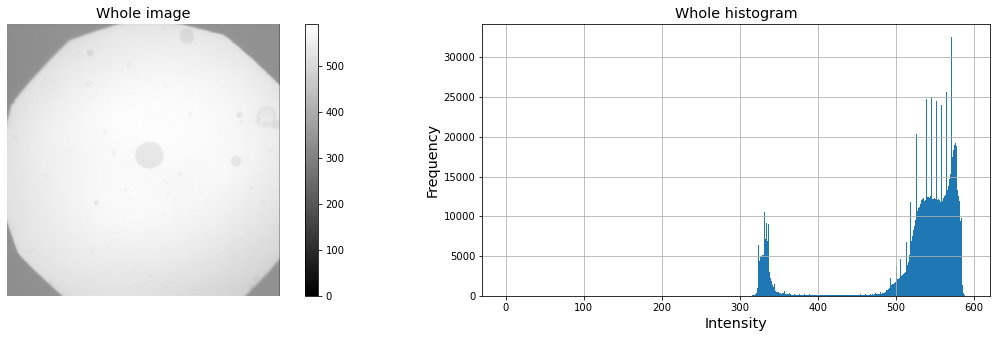

In [3]:
# Read the RICM image
ricm_img = io.imread(f"Data/{experiment}/data/{whole_img}.tif")

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.imshow(ricm_img, cmap="gray")
plt.axis('off')
plt.title('Whole image', fontsize='x-large')
plt.colorbar();

plt.subplot(122)
plt.hist(ricm_img.ravel(), bins=500)
plt.title('Whole histogram', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
#plt.xlim(0,3000)
plt.grid();

### Read the GUV image and subtract the base line

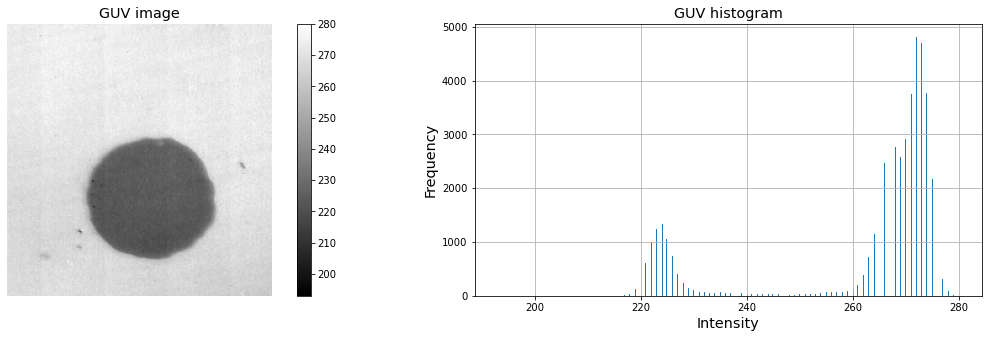

In [4]:
# Read the GUV image
img = io.imread(f"Data/{experiment}/data/{object_img}.tif")

# Subtract the base line
img = img - 310

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title('GUV image', fontsize='x-large')
plt.colorbar();

plt.subplot(122)
plt.hist(img.ravel(), bins = 500)
plt.title('GUV histogram', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
#plt.xlim(0,3000)
plt.grid();

### Define the RICM model

Y0 = 0.01, A = 0.24, h0 = 32.11


/home/ahmed/Repositories/Membrane-Topography/RICM_VESICLE.py:364: RuntimeWarning: invalid value encountered in arccos
  return (self.l/(4*np.pi*self.n_outer)) * (np.arccos((Y0-img_normalized)/A) - 2*np.pi*self.p) + h0


Y0 = 0.01, A = 0.24, h0 = 32.11


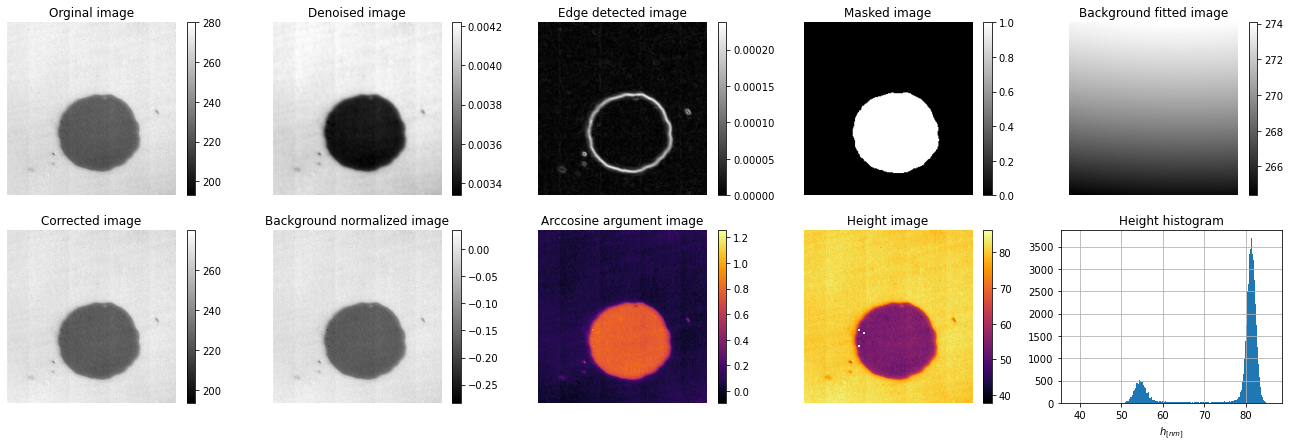

Y0 = 0.01, A = 0.24, h0 = 32.11


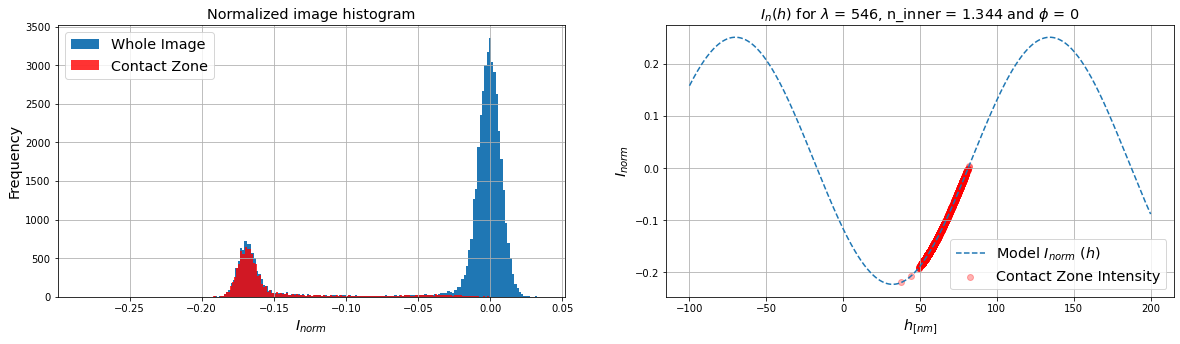

In [5]:
# Define the RICM class with certain n_inner
ricm = RICM(img, n_inner=1.344, p=0, hole=3)

# Display the way to the RICM height mapping step by step
ricm.show_summary(save=True)

# Extract the hieght on the contact zone
i_height, _ = ricm.model_fitting(h=np.linspace(-100, 200, 600), show=True)

### Fit a gaussian on the adhesion zone

The height of the GUV is 54.61 nm


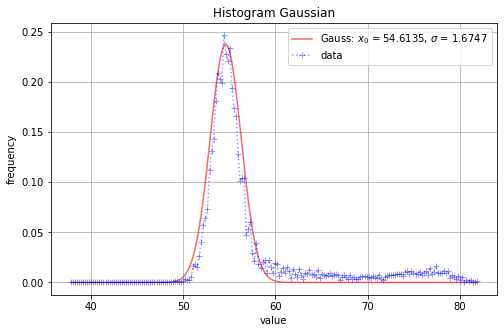

In [6]:
# Fit a gaussian on the adhesion zone histogram
gauss = Fit_Gaussian(i_height, normalized=True)
height, _ = gauss.hist_fitting(show=True)

# Print the height in nano meter
print(f'The height of the GUV is {height:.2f} nm')

### Save the images in tif format

In [7]:
# Create the results directory
path = f'Data/{experiment}/results/{object_img}_{height:.2f}nm'
try:
    # Create a directory for the results
    os.mkdir(path)
except:
    print(f'The same exact measurments have been saved before in:\n{path}')
    
# Save the results
Image.fromarray(img).save(f'{path}/original.tif')
Image.fromarray(ricm.nl_denoise()).save(f'{path}/nl_denoise.tif')
Image.fromarray(ricm.edge_detection()).save(f'{path}/edge_detection.tif')
Image.fromarray(ricm.mask()).save(f'{path}/mask.tif')
Image.fromarray(ricm.background_fitting()).save(f'{path}/background_fitting.tif')
Image.fromarray(ricm.correct()).save(f'{path}/correct.tif')
Image.fromarray(ricm.background_normalization()).save(f'{path}/background_normalization.tif')
Image.fromarray(ricm.height()).save(f'{path}/height.tif')

Y0 = 0.01, A = 0.24, h0 = 32.11
